In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mlp import MLP
from processing import patterns, persistance, shift
from metrics import all_metrics_from_dataframe
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [104]:
df = pd.read_csv('australia.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').rolling(6).mean().iloc[6::6]
df.index.name = None
df = df.interpolate(method='polynomial', order=5, axis=0).clip(lower=0)

In [105]:
LAGS = 4
HORIZONS = 6
INITS = 1 
HIDDEN_LAYERS = [10]
ACTIVATION = 'relu'
OPTIMIZER = 'adam'
LOSS = 'mse'
VALIDATION_SPLIT = 0.2
EPOCHS = 200

CENTRAL = 'KIATAWF1'

serie = df[CENTRAL]
index = serie.index
serie.describe()


count    8759.000000
mean       14.956560
std        10.635132
min         0.000000
25%         4.750000
50%        14.375000
75%        25.487500
max        30.900000
Name: KIATAWF1, dtype: float64

In [106]:

train, test = train_test_split(serie, test_size=.33, shuffle=False)
train_idx, test_idx = train_test_split(index, test_size=.33, shuffle=False)
X_train, Y_train = patterns(train, LAGS, HORIZONS, dropnan=True, index=train_idx)
X_test = patterns(test, LAGS, dropnan=False, index=test_idx)


In [107]:
model = MLP(n_lags=LAGS, n_horizons=HORIZONS, n_inits=INITS)
model.build(hidden_layers=HIDDEN_LAYERS, activation=ACTIVATION, optimizer=OPTIMIZER, loss=LOSS)
model.train(X_train.values, Y_train.values, validation_split=VALIDATION_SPLIT, epochs=EPOCHS)
pred = model.predict(X_test.values)
pred.index = test_idx
pred

Epoch 1/200
147/147 [==============================] - 0s 2ms/step - loss: 29.2671 - val_loss: 22.6184
Epoch 2/200
147/147 [==============================] - 0s 1ms/step - loss: 19.4450 - val_loss: 18.6772
Epoch 3/200
147/147 [==============================] - 0s 1ms/step - loss: 16.9924 - val_loss: 17.2983
Epoch 4/200
147/147 [==============================] - 0s 767us/step - loss: 15.2030 - val_loss: 16.2993
Epoch 5/200
147/147 [==============================] - 0s 795us/step - loss: 14.5462 - val_loss: 18.1788
Epoch 6/200
147/147 [==============================] - 0s 676us/step - loss: 14.1590 - val_loss: 16.1575
Epoch 7/200
147/147 [==============================] - 0s 692us/step - loss: 13.9890 - val_loss: 15.7546
Epoch 8/200
147/147 [==============================] - 0s 655us/step - loss: 13.9077 - val_loss: 15.7918
Epoch 9/200
147/147 [==============================] - 0s 699us/step - loss: 13.9440 - val_loss: 18.7575
Epoch 10/200
147/147 [==============================] - 0s 66

,t+1,t+2,t+3,t+4,t+5,t+6
2018-09-02 13:00:00+10:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-02 14:00:00+10:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-02 15:00:00+10:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-02 16:00:00+10:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-02 17:00:00+10:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2018-12-31 19:00:00+10:00,11.428429,8.552522,8.280828,9.335155,6.832157,7.834205
2018-12-31 20:00:00+10:00,12.522225,10.759546,8.920712,11.017819,9.840023,10.626324
2018-12-31 21:00:00+10:00,20.365017,11.548759,11.314064,10.957820,11.877180,12.396652
2018-12-31 22:00:00+10:00,29.743427,17.888680,11.680586,11.272271,11.856316,12.073645


In [108]:
all_metrics_from_dataframe(pred, test)

,t+1,t+2,t+3,t+4,t+5,t+6
mse,16.847096,38.073647,54.286149,67.166283,79.448995,86.766933
rmse,4.104521,6.170385,7.367913,8.195504,8.913417,9.314877
bias,0.208349,0.371566,0.061468,0.443864,0.750012,0.957430
mae,2.870425,4.515421,5.595819,6.474356,7.156835,7.607125
mape,0.383296,0.478418,0.562771,0.568610,0.601860,0.594654
corr_coef,0.920516,0.811961,0.717294,0.633720,0.554398,0.496001
std_ratio,0.943231,0.882147,0.810602,0.740210,0.714361,0.661711
rmsd,4.100689,6.160937,7.367841,8.184888,8.883835,9.267937
ss4,0.044721,0.026741,0.015833,0.009217,0.005281,0.003202


In [109]:
pers = persistance(test, 6, index=test_idx)
all_metrics_from_dataframe(pers, test)

,t+1,t+2,t+3,t+4,t+5,t+6
mse,1.811489e+01,4.177926e+01,6.288383e+01,8.203986e+01,9.951418e+01,1.157129e+02
rmse,4.256159e+00,6.463688e+00,7.929933e+00,9.057586e+00,9.975679e+00,1.075699e+01
bias,-4.176502e-03,-9.472199e-03,-1.427814e-02,-1.558320e-02,-1.464846e-02,-1.275409e-02
mae,2.836285e+00,4.462377e+00,5.619778e+00,6.571417e+00,7.417609e+00,8.126397e+00
mape,1.063826e+14,2.613330e+14,5.337770e+14,8.396594e+14,1.190349e+15,1.473478e+15
corr_coef,9.174603e-01,8.095818e-01,7.133768e-01,6.261360e-01,5.465186e-01,4.726759e-01
std_ratio,9.999433e-01,9.997471e-01,9.996161e-01,9.997668e-01,9.999285e-01,1.000055e+00
rmsd,4.256149e+00,6.463660e+00,7.929888e+00,9.057533e+00,9.975618e+00,1.075693e+01
ss4,4.428219e-02,2.684868e-02,1.618661e-02,9.606267e-03,5.575704e-03,3.119849e-03


No handles with labels found to put in legend.


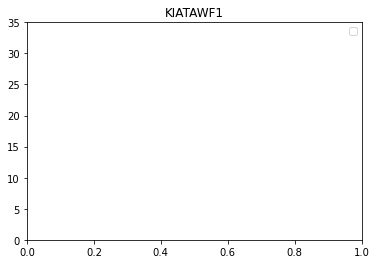

In [110]:
for h in range(1,HORIZONS-5):
    plt.plot(pred[f't+{h}'].values[:100], label=f'horizon {h}')
plt.ylim([0,35])
plt.legend()
plt.title(CENTRAL)
plt.show()

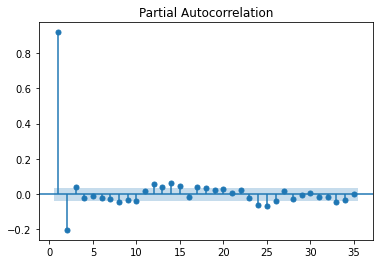

In [111]:
plot_pacf(test, zero=False)
plt.show()